In [1]:
#|hide
## Standard libraries
import os
import math
import numpy as np
import time
from fastcore.all import *
from nbdev.showdoc import *

# Configure environment
os.environ['XLA_PYTHON_CLIENT_PREALLOCATE']='false' # Tells Jax not to hog all of the memory to this process.
import nest_asyncio
nest_asyncio.apply()

## Imports for plotting
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import set_matplotlib_formats
# set_matplotlib_formats('svg', 'pdf') # For export
from matplotlib.colors import to_rgba
import seaborn as sns
sns.set()

## Progress bar
from tqdm.auto import tqdm, trange

from functools import partial

## project specifics
import diffusion_curvature
import pygsp
import jax
import jax.numpy as jnp
from diffusion_curvature.graphs import *
from diffusion_curvature.datasets import *
from diffusion_curvature.core import *
from diffusion_curvature.utils import *
# from diffusion_curvature.comparison_space import *
from diffusion_curvature.sadspheres import *
from diffusion_curvature.kernels import *

%load_ext autoreload
%autoreload 2
    
jax.devices()
jax.default_device = jax.devices("cpu")

# Sign Prediction Tests
> Comparisons between Diffusion Curvature and the Competition

Here we employ saddles and spheres of increasing dimension to test our model's ability to detect sign.

# Machinery

In [2]:
dims = [2, 3, 4, 5, 6]
num_pointclouds = 20

In [3]:
SS1 = SadSpheres(
    dimension = dims, # Dimension of saddles and spheres
    num_pointclouds = num_pointclouds, # num pointclouds to make in total
    num_points = 2000, # num points per pointclouds
    noise_level = 0, # from 0 to 1. 1 is all noise.
    include_planes=True,
)

Loaded evaluations on methods ['ground truth', 'Diffusion Curvature (Entropic)', 'Diffusion Curvature (Wasserstein)', 'Hickok & Blumberg']


In [4]:
SS1.imported_methods

['ground truth',
 'Diffusion Curvature (Entropic)',
 'Diffusion Curvature (Wasserstein)',
 'Hickok & Blumberg']

In [5]:
SS1.save_results()

In [27]:
# graph_former = partial(get_curvature_agnostic_graph, k = dim*2, )
graph_former = partial(get_fixed_graph, sigma = 0.2, alpha = 1)
for X in tqdm(SS1):
    if "Diffusion Curvature (Entropic)" not in SS1.imported_methods:
        G = graph_former(X)
        DC = DiffusionCurvature(
            laziness_method="Wasserstein",
            flattening_method="Fixed",
            comparison_method="Ollivier",
            graph_former = graph_former,
            points_per_cluster=None,  # construct separate comparison spaces around each point
            comparison_space_size_factor=1,
        )
        ks = DC.curvature(G, dim = X.shape[1] - 1, t = 25)
        SS1.update(ks[0], method_name="Diffusion Curvature (Entropic)")
    if "Diffusion Curvature (Wasserstein)" not in SS1.imported_methods:
        G = graph_former(X)
        DC = DiffusionCurvature(
            laziness_method="Entropic",
            flattening_method="Fixed",
            comparison_method="Subtraction",
            graph_former = graph_former,
            points_per_cluster=None,  # construct separate comparison spaces around each point
            comparison_space_size_factor=1,
        )
        ks = DC.curvature(G, dim = X.shape[1] - 1, t = 25)
        SS1.update(ks[0], method_name="Diffusion Curvature (Wasserstein)")
    if "Diffusion Curvature (Trajectory Normalized)" not in SS1.imported_methods:
        DC = DiffusionCurvature2()
        ks = DC.fit(X, dim = X.shape[1] - 1, idx = 0, ts = list(range(1,40)))
        SS1.update(ks.item(), method_name = "Diffusion Curvature (Trajectory Normalized)")

  0%|          | 0/300 [00:00<?, ?it/s]

In [26]:
SS1.labels['ks']['Diffusion Curvature (Trajectory Normalized)']

[Array([-0.33969688], dtype=float32),
 Array([0.11642599], dtype=float32),
 Array([0.08291674], dtype=float32),
 Array([-0.08392525], dtype=float32),
 Array([0.20624256], dtype=float32),
 Array([0.15004635], dtype=float32),
 Array([-0.36801577], dtype=float32),
 Array([0.15882969], dtype=float32),
 Array([-0.1531353], dtype=float32),
 Array([-0.17494106], dtype=float32),
 Array([-0.13604736], dtype=float32),
 Array([-0.0303297], dtype=float32),
 Array([-0.33587503], dtype=float32),
 Array([0.23514032], dtype=float32),
 Array([0.00613785], dtype=float32),
 Array([-0.38051176], dtype=float32),
 Array([0.12687492], dtype=float32),
 Array([0.05382013], dtype=float32),
 Array([-0.14299631], dtype=float32),
 Array([0.34607124], dtype=float32),
 Array([0.02301455], dtype=float32),
 Array([-0.26840305], dtype=float32),
 Array([-0.00474596], dtype=float32),
 Array([0.04316711], dtype=float32),
 Array([-0.21160316], dtype=float32),
 Array([0.1790433], dtype=float32),
 Array([0.15643072], dtype=f

In [16]:
len(SS1.labels['ks']['ground truth'])

300

In [19]:
len(SS1.labels['ks'][''])

300

In [17]:
SS1.labels['ks'].keys()

dict_keys(['ground truth', 'Diffusion Curvature (Entropic)', 'Diffusion Curvature (Wasserstein)', 'Hickok & Blumberg', 'Diffusion Curvature (Trajectory Normalized)'])

In [16]:
len(SS1.labels['ks']['ground truth'])

300

In [24]:
SS1.table()

ValueError: shapes (300,1) and (300,) not aligned: 1 (dim 1) != 300 (dim 0)

ValueError: `bins` must be 1d, when an array

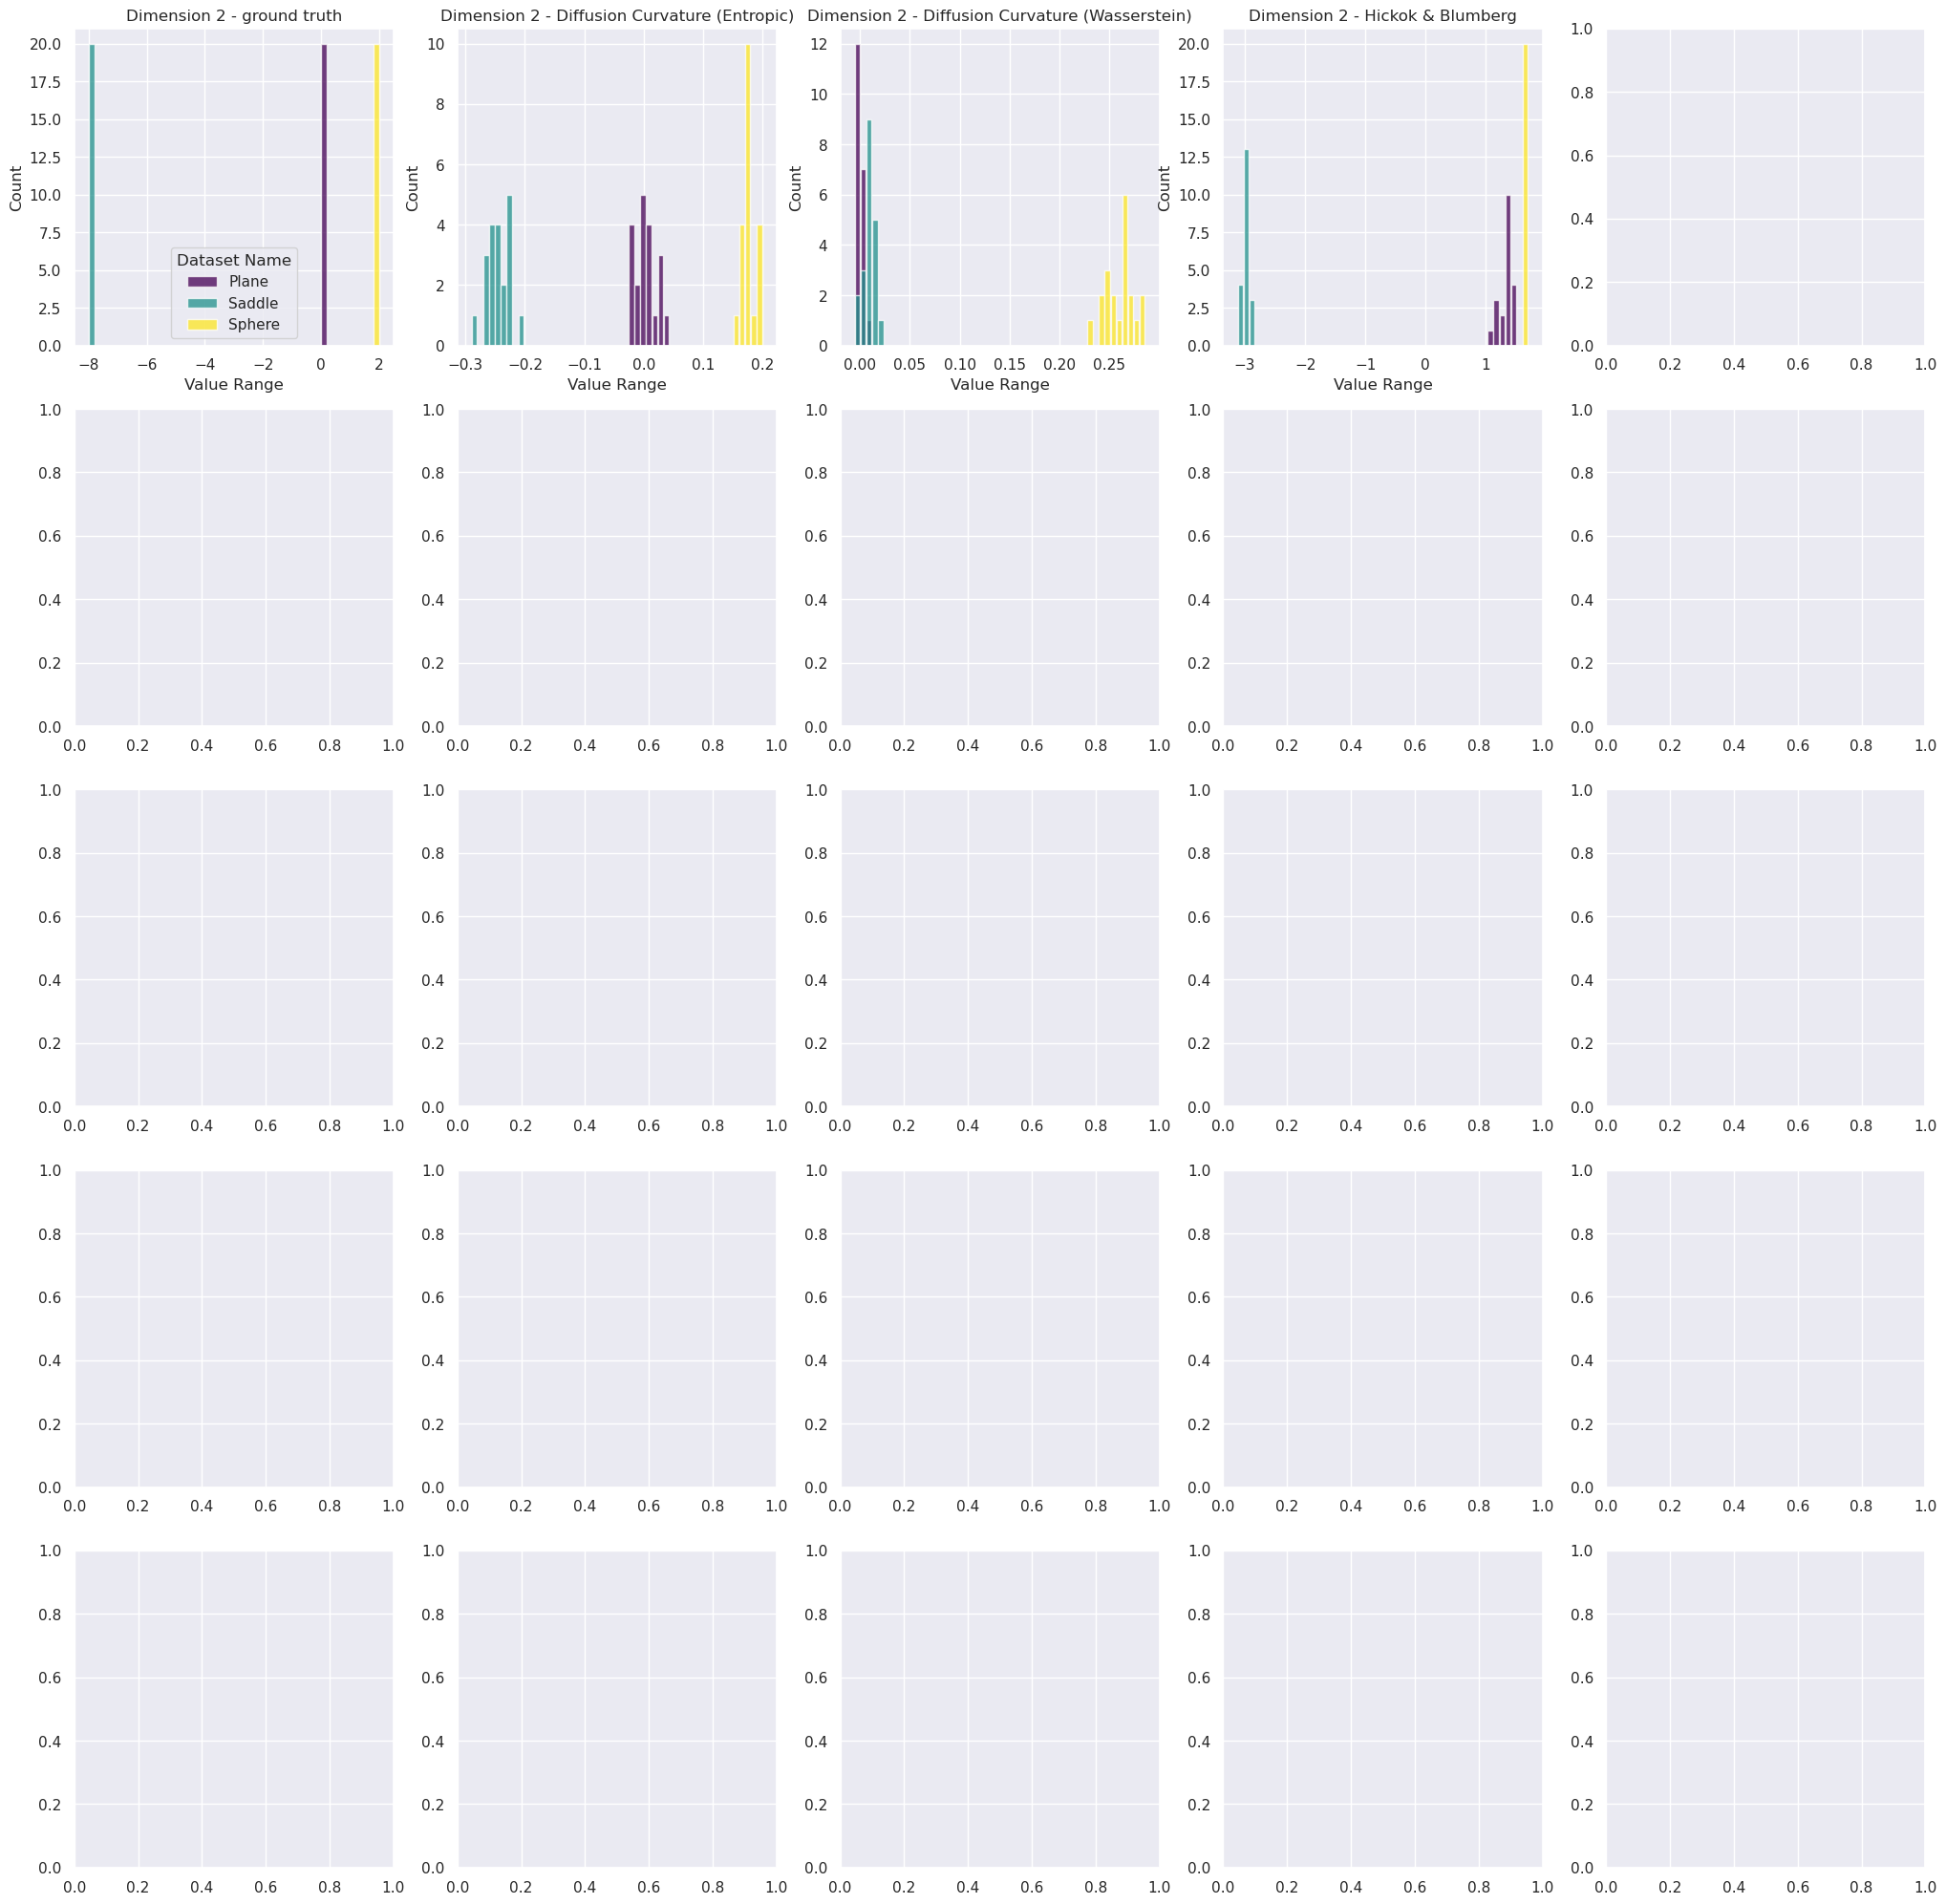

In [25]:
#| label: fig-sadspheres
#| fig-cap: Predicted curvatures of Saddles and Spheres in dimensions 2-6. Diffusion Curvature robustly distinguishes between the signs of the data, even in high dimensions, and with relative sparsity.
#| fig-alt: ...
SS1._aggregate_labels()
SS1.plot_by_dimension()

# Conclusion